# Identifying Acquisitions in News Articles Using Few-Shot Learning

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [1]:
import pandas as pd
df1 = pd.read_csv('/content/articles.csv')
df2 = pd.read_csv('/content/articles2.csv')

# Data Preprocessing
We have two datasets, each containing news article headlines and a short excerpt from each.


*   The first dataset contains 100 articles spanning from 09-27-2024 to 10-27-2024. Query restrictions included any English-language article containing "acquires" in the article title and body, gathered from over 150,000 news sources. The resulting articles in this dataset came from the following sources:

  * 'Gizmodo.com', 'BBC News', 'Springwise.com',
'The Next Web','Theregister.com', 'PetaPixel', 'Timesrecordnews.com','Comecruisewith.com', 'Zmh.org', 'Deadline', 'IndieWire','Ghacks Technology News', 'Forbes', 'Biztoc.com', 'Sneaker News', 'Biopharmadive.com'
*   The second dataset contains 200 articles spanning from 09-25-2024 to 10-27-2024. Query restrictions included any English-language article containing "merge*" or "acqui*" in the article title and body, also gathered from over 150,000 news sources. The resulting articles in this dataset came from the following sources:

  * 'Dailymail.co.uk', 'OregonLive', 'CNBC', 'Patch' 'Variety', 'Axios', 'Star Tribune', 'New York Post', 'CBS News', 'ABC News', 'Reuters', 'Chicago Tribune', 'People', 'NJ.com', 'Philadelphia Inquirer', 'The Guardian', 'Dallas Morning News', 'Yahoo', 'USA Today', 'Al Jazeera', 'Breitbart', 'The Hill', 'BBC', 'Us Weekly', 'Newsmax', 'Atlanta Journal-Constitution', 'Zero Hedge', 'The Independent', 'The Telegraph', 'Cleveland.com', 'NBC News', 'San Francisco Chronicle', 'Associated Press', 'The Verge', 'New York Daily News', 'HuffPost', 'CNN', 'The Sun', 'Fox News', 'Politico', 'Western Journal'

In [3]:
df2 = df2.rename(columns={'content': 'title', 'title': 'content'})

In [4]:
salesdf = pd.concat([df1, df2], ignore_index=True).dropna()

In [5]:
# Remove anything after ellipsis as it indicates end of article excerpt
salesdf['content'] = salesdf['content'].str.replace(r'….*|\.\.\..*', '', regex=True)

# Merge title and content
salesdf['text'] = salesdf['title'] + ':' + salesdf['content']

# format cat column
salesdf['label'] = salesdf['Cat'].str.lower().str.replace(' ', '_')

In [6]:
# keep only relevant columns - text and label
salesdf2 = salesdf.drop(columns=['content', 'title', 'Cat'])

## Prepare Data for Model

In [10]:
#!pip install setfit datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00


In [38]:
from datasets import Dataset, DatasetDict, concatenate_datasets
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from transformers import EarlyStoppingCallback
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# randomly shuffle data
datafinal = salesdf2[["text", "label"]].sample(frac=1)

In [9]:
# create HuggingFace dataset using datafinal dataframe
dataset = Dataset.from_pandas(datafinal, preserve_index=False)

# 70% train, 30% test + validation
train_testvalid = dataset.train_test_split(test_size=0.3)

# Split the 30% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

# encode labels into binary (1, 0) using training data as base
ds["train"] = ds["train"].class_encode_column("label")
class_label_feature = ds["train"].features["label"]

ds["test"] = ds["test"].cast_column("label", class_label_feature)
ds["valid"] = ds["valid"].cast_column("label", class_label_feature)


Flattening the indices:   0%|          | 0/205 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/205 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/44 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/44 [00:00<?, ? examples/s]

In [10]:
test_dataset = ds["test"]
train_dataset = ds["train"]
valid_dataset = ds["valid"]

# Text Classification Using SetFit

## Model Architecture

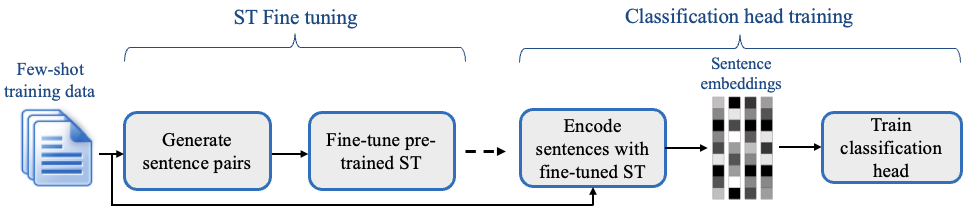

SetFit leverages few-shot and contrastive learning to learn effectively from limited data. The process by which the model does this can be summarized in 2 stages:
1.   Fine-tune Sentence Transformer pre-trained model on few labeled examples. It leverages contrastive learning, pairing negative and positive examples and generating vectors for each example.
2.  Training classifier head on the generated embeddings from the fine-tuned Sentence Transformer using corresponding class label.


## Relevant Model Parameters
*  Base Model: all-mpnet-base-v2 is a sentence transformers model which  maps sentences & paragraphs to a 768 dimensional dense vector space that allows it to capture semantic meaning. The base MPNet architecture combines masked language modeling and permuted language modeling for contextual learning.
*   Logging Step: Every 50 steps, information about training progress will be recorded in the logger (weights and biases).
*   Batch Size: The number of training examples utilized in one iteration of model is 64.
*   Number of Iterations: odel will update its weights based on the training data 20 times.
*   Number of Epochs: The model will go through the entire dataset once.
*   Eval Steps: Every 50 steps, the model’s performance will be assessed on the validation dataset.
*   Loss: Cosine Similarity Loss measures the degree to which two inputs are similar or dissimilar using the cosine distance between them in a vector space.
*   Metric for Best Model: The embedding loss from evaluations will be used to identify the optimal point to save the model.
*   EarlyStoppingCallback: If the evaluation metric does not improve for 2 consecutive evaluations, training will be stopped. This helps prevent overfitting and saves training time.

In [48]:
# custom function which calculates relevant metrics
def custom_metrics(y_pred, y_test):
    """Calculate accuracy, precision, recall and F1 metrics for model evaluation."""
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [16]:
# Load a SetFit model from Hub
model_id = "sentence-transformers/all-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

# training arguments
args = TrainingArguments(
        logging_steps=50,
        run_name="setfit_early_stopping",
        batch_size=64,
        num_iterations=20,
        num_epochs=1,
        eval_steps=50,
        save_steps=50,
        loss = CosineSimilarityLoss,
	      report_to = 'wandb',
        load_best_model_at_end=True,
        metric_for_best_model="eval_embedding_loss",
        seed=random.randint(0, 100000))

# instill early stopping
callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

# create trainer
trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        args=args,
        eval_dataset=valid_dataset,
        metric=custom_metrics,
        callbacks=callbacks,
    )

# Train and evaluate
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Using `eval_strategy="steps"` as `eval_steps` is defined.


Map:   0%|          | 0/205 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 8200
  Batch size = 64
  Num epochs = 1


wandb: Currently logged in as: vidhipatel975. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
50,0.134500,0.308298
100,0.006700,0.297988


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [17]:
# evaluating on testing data
trainer.eval_dataset = test_dataset
metrics = trainer.evaluate()
print(metrics)

***** Running evaluation *****


{'accuracy': 0.9772727272727273, 'precision': 1.0, 'recall': 0.8333333333333334, 'f1': 0.9090909090909091}


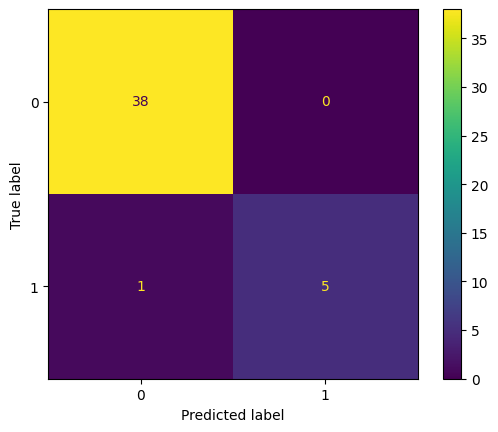

In [38]:
# confusion matrix of test dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_dataset['label'], model.predict(test_dataset['text']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [20]:
# save model
model.save_pretrained("setfit-sales-small")

# Predicting on Sample Inputs Using Trained Model
Using some articles I found on Google.

In [27]:
model.predict(['UAB’s $450 million acquisition of Birmingham’s first hospital will soon be finalized: The acquisition process began in June. UAB Health is seeking $680 million in financing to complete the deal by Friday, Nov. 1.'])

tensor([0])

In [25]:
model.predict(['Concord Music Closes $850 Million in Financing for ‘Strategic Growth and Acquisitions’: Concord, which bought the Genesis catalog for $300 million and Round Hill Music for $468 million, has secured another $850 million in...'])

tensor([0])

In [26]:
model.predict(['Mo’Bettahs has been acquired by Blue Marlin Partners and Trive Capital: As part of the deal, Savory Fund, which acquired the chain in 2017, and founders Kimo and Kalani Mack will retain minority stakes.'])

tensor([1])

In [28]:
model.predict(["Myer and Premier Investments Announce Major Retail Merger: Premier Investments Limited (AU:PMV) has released an update. Myer Holdings Ltd has announced a significant merger with Premier Investments..."])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([1])

# Reflection

The few-shot learning capabilities of SetFit look promising for parsing news articles on completed acquistions. Despite having only ~20 positive labels in the training dataset, the model performed well with a F1 score of 0.91 on the testing dataset. The precision and recall  are also relatively high indicating the model minimizes false positives and false negatives. This is especially notable given the inherent challenges posed by class imbalance, where the minority class (acquisition news) is significantly underrepresented compared to the majority class (non-acquisition news). To further improve perforamance, hyperparameter tuning can be conducted.

However, these results should be taken with a grain of salt as the testing dataset was relatively small. It could be that the model overtrained on the few minority class examples provided during training and then been able to perform relatively well on testing data due to high similarity between training and testing dataset. To better evaluate the model's capabilities, it would be beneficial to conduct further testing with a larger and more diverse dataset.

Articles matching only three regex patterns were queried in the datasets used. Incorporating a broader range of minority class examples—capturing different reporting styles—would likely enhance the model's robustness. SetFit's unique properties allow for effective few-shot learning, meaning it doesn’t necessarily require a large number of examples to improve. By carefully selecting and diversifying these minority class examples, we can harness SetFit's strengths to improve generalizability while maintaining efficiency.